This notebook evaluates a manual Vector Autoregressive Model with exogenous variables for conditional forecasting.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd
import sys
import regex
from collections import Counter
import math

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col, new_col in zip(cols_to_keep, new_col_names)}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def split_coin_and_exogenous_variables(df, dep_cols, ex_cols, coin):
    '''
    Function to split the exogenous (independent) variables 
    from the dependent variables for a given coin. 
    Takes a dataframe as returned by
    df_long_to_wide and returns new dataframes of only the 
    dependent and exogenous variables for the chosen coin.
    
    Inputs:
        df (pd.DataFrame) :
            Wide dataframe with both dependent and exogenous variables
            as returned by the function df_long_to_wide
            
        dep_cols (list) :
            List of column names for the dependent variables without
            any coin specific suffixes (e.g. Target rather than Target_0)
            
        ex_cols (list) :
            List of column names for the exogenous variables without
            any coin specific suffixes (e.g. Open rather than Open_0)
            
        coin (int) :
            Integer Asset ID corresponding to the desired coin
            
    Outputs:
        dep_df (pd.DataFrame) :
            Wide dataframe with only dependent variables for the chosen coin
    
        ex_df (pd.DataFrame) :
            Wide dataframe with only exogenous variables for the chosen coin
    '''
    
    # make deep copy to not alter original
    df = df.copy()
    
    # keep every coin for VAR model
    dep_cols = [col + "_" + str(coin)
                for col in dep_cols
                for coin in asset_details_df.loc[:, "Asset_ID"]
              ]
    # only get specified coin for exo variables
    ex_cols = [col + "_" + str(coin) 
               for col in ex_cols 
              ]
    
    dep_df = df.loc[:, dep_cols]
    ex_df = df.loc[:, ex_cols]
    
    return dep_df, ex_df

def weight_df(df, factor, weight_factor = None):
    '''
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        weight_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df * factor
    
    if weight_factor is not None:
        
        weight_factor.index = df.columns
        df = df * weight_factor
        
    return df

def unweight_df(df, factor, col_factor):
    '''
    Unweights each entry in df by factor, and each column additionally
    by col_factor.
    
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        col_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df / factor
    
    if col_factor is not None:
        
        col_factor.index = df.columns
        df = df / col_factor
        
    return df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

dep_cols = ["Target"]
ex_cols = ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"]

df.loc[:, ex_cols] = (np.log(df.loc[:, ex_cols])).diff()

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", dep_cols + ex_cols, "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

standard_train_dep_df_list = []
standard_train_ex_df_list = []
standard_test_dep_df_list = []
standard_test_ex_df_list = []

factor = 1000
# get dependent variables in test set together
test_dep_df, _ = split_coin_and_exogenous_variables(standard_test_df, 
                                                    dep_cols, ex_cols, "1")

for coin in asset_details_df.loc[:, "Asset_ID"]:
    
    standard_train_dep_df, standard_train_ex_df = split_coin_and_exogenous_variables(
                                                                            standard_train_df, 
                                                                            dep_cols, ex_cols, 
                                                                            coin)
    
    standard_train_dep_df = weight_df(standard_train_dep_df, factor, asset_details_df.loc[:, "Weight"])
    #standard_test_dep_df = weight_df(standard_test_dep_df, factor, None)
    
    standard_train_dep_df_list.append(standard_train_dep_df)
    standard_train_ex_df_list.append(standard_train_ex_df)
    
    standard_test_dep_df, standard_test_ex_df = split_coin_and_exogenous_variables(
                                                                        standard_test_df, 
                                                                        dep_cols, ex_cols, 
                                                                        coin)
    
    standard_test_dep_df_list.append(standard_test_dep_df)
    standard_test_ex_df_list.append(standard_test_ex_df)

In [5]:
del df
del standard_train_df
del standard_test_df
del _
del standard_train_dep_df
del standard_train_ex_df
del standard_test_ex_df
del clean_dates
del standardize_data
del df_long_to_wide
del split_coin_and_exogenous_variables

gc.collect()

23

In [6]:
standard_train_dep_df_list[0]

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
timestamp,,,,,,,,,,,,,,
1555079640,-8.848435,-7.693108,-12.762592,-3.179203,-1.724596,-8.477328,5.947297,19.171531,-4.585157,-3.168665,-13.003806,30.357338,-21.654077,21.780511
1555079700,-3.929931,-6.895995,-4.953509,-1.698134,2.185164,-10.475892,7.869149,25.082228,-7.532698,-2.549730,-12.883231,0.000000,-21.651670,26.934455
1555079760,-6.861637,-2.168963,-9.094039,-3.615153,-14.640859,-11.469192,3.612200,23.700765,0.046123,-4.959711,-16.859533,29.580781,-21.649262,30.771134
1555079820,-0.532618,2.435367,-10.222229,-9.768595,-0.775557,-7.139544,2.302065,27.836038,-1.746704,-6.477979,-10.281260,2.271304,-21.646855,33.323378
1555079880,-12.997653,0.000000,-11.232208,-4.250412,-0.028656,-10.005232,0.654200,28.145960,-7.499752,-6.171797,-12.443218,30.457288,-21.644447,33.311369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,2.744094,16.512819,-13.471912,-5.257149,0.786222,0.261943,-3.629784,-22.371355,-0.064397,3.276561,48.365056,10.237505,3.155846,-5.231632
1624405200,8.669991,21.600957,-15.094906,-4.068323,-0.903620,3.344876,2.939453,-20.888268,-1.326830,4.766670,44.987969,10.542078,5.518253,-9.792229
1624405260,3.382728,25.432328,-12.191278,-2.358015,-2.931203,8.465620,2.786093,-20.802003,0.961505,6.626447,33.599581,15.437362,5.643525,-5.791865


In [7]:
standard_train_ex_df_list[0]

,Open_2,Close_2,High_2,Low_2,Count_2,Volume_2,VWAP_2
timestamp,,,,,,,
1555079640,8.126158,8.126486,8.130022,8.120389,1,-6.318712,8.126311
1555079700,8.127536,8.126890,8.130066,8.121574,0,-6.688435,8.127444
1555079760,8.127290,8.125498,8.128612,8.121247,0,-7.604634,8.126142
1555079820,8.125712,8.125694,8.129625,8.119834,0,-8.029389,8.125970
1555079880,8.124744,8.125251,8.129430,8.120490,0,-8.418831,8.124996
...,...,...,...,...,...,...,...
1624405140,5.960016,5.961739,5.960152,5.961238,0,-7.080361,5.960900
1624405200,5.961808,5.961189,5.961028,5.961492,0,-7.210413,5.961423
1624405260,5.961169,5.959937,5.959867,5.960748,0,-7.228152,5.960294


In [8]:
standard_test_dep_df_list[0]

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
timestamp,,,,,,,,,,,,,,
1624405440,0.005524,0.007666,-0.001197,-0.002951,-0.002057,0.002168,0.000865,-0.009090,0.002707,0.001459,0.005235,0.010136,0.004384,-0.004115
1624405500,0.007835,0.013220,-0.001430,-0.003119,0.004599,0.001220,-0.002387,-0.007924,0.001617,0.002208,0.002967,0.008768,0.011461,-0.003292
1624405560,0.005463,0.003928,-0.001494,-0.001243,0.001828,-0.001406,-0.002253,-0.006417,0.001282,0.003931,0.003012,-0.001801,0.003572,0.000253
1624405620,0.003554,0.002770,-0.001203,0.000759,-0.000611,-0.000607,0.001865,-0.005295,0.001187,0.000273,0.002526,-0.006199,0.000289,-0.001437
1624405680,0.003438,-0.003693,-0.000965,0.001166,-0.003541,0.001265,0.002602,-0.006012,0.001080,-0.000477,0.000898,-0.009373,-0.005821,-0.000081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632181200,0.002919,0.002325,0.002084,0.000941,0.000468,-0.001309,0.002442,-0.001876,0.000199,-0.000743,-0.003660,0.000664,0.001008,-0.001142
1632181260,-0.001943,0.000995,0.003246,0.000416,-0.000676,-0.000736,0.000665,-0.004123,-0.003477,-0.000860,-0.000785,-0.002656,-0.001030,-0.001968
1632181320,-0.000911,0.001499,0.003108,-0.000383,-0.001177,-0.000491,-0.000453,-0.003768,-0.002437,-0.001822,-0.001108,-0.003244,0.000006,-0.000885


In [9]:
standard_test_ex_df_list[0]

,Open_2,Close_2,High_2,Low_2,Count_2,Volume_2,VWAP_2
timestamp,,,,,,,
1624405440,5.956871,5.955046,5.956449,5.954841,0,-6.709304,5.955906
1624405500,5.955125,5.954034,5.954452,5.955438,0,-6.981645,5.953919
1624405560,5.954075,5.953808,5.953402,5.954299,0,-7.236083,5.954259
1624405620,5.953390,5.956535,5.956889,5.953930,0,-6.442228,5.955473
1624405680,5.957656,5.956504,5.955800,5.956936,0,-7.229406,5.956507
...,...,...,...,...,...,...,...
1632181200,5.563534,5.563789,5.563616,5.564390,-1,-6.940506,5.563929
1632181260,5.563927,5.562538,5.562110,5.563917,-1,-7.502275,5.562688
1632181320,5.562665,5.564261,5.562703,5.564750,-1,-7.334362,5.563224


In [10]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Define and Evaluate Model

In [11]:
def rmse(preds, true):
    '''
    Calculates Root Mean Squared Error (RMSE) between
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        rmse (float) :
            RMSE as a float
    '''
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # get squared error for each coin
    se = (np.square(true.subtract(preds))).sum()

    # get mean squared error for each coin
    mse = se / len(true)

    # get root mean squared error for each coin
    rmse = (mse)**0.5
    
    return rmse
    
def binary_accuracy(preds, true):
    '''
    Calculates binary accuracy between
    continuous predictions and true values. Binary accuracy
    is 1 when the forecasted Target is of the same sign
    as the true Target, and zero otherwise.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        bin_pos_acc (pd.Series) :
            Binary accuracy for only positively valued
            predictions as a float
            
        bin_neg_acc (pd.Series) :
            Binary accuracy for only negatively valued
            predictions as a float
    
        bin_acc (pd.Series) :
            Binary accuracy as a float
    '''
    
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # find which predictions SHOULD have been
    # greater or less than zero
    true_pos = preds[true > 0]
    true_neg = preds[true < 0]
    
    num_pos_correct = true_pos[true_pos > 0].count()
    num_neg_correct = true_neg[true_neg < 0].count()
    num_correct = num_pos_correct + num_neg_correct
    
    num_total_pos = true_pos.count()
    num_total_neg = true_neg.count()
    num_total = true.count()
    
    bin_pos_acc = num_pos_correct / num_total_pos
    bin_neg_acc = num_neg_correct / num_total_neg
    bin_acc = num_correct / num_total
    
    return bin_pos_acc, bin_neg_acc, bin_acc

def corr(preds, true):
    '''
    Calculates Pearson correlation coefficient between 
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        corr (pd.Series) :
            Pearson correlation coefficient for
            each group
    '''
    
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    corr = preds.corrwith(true)
    
    return corr

def weighted_corr(preds, true, weights):
    '''
    Calculates weighted Pearson correlation coefficient 
    between continuous predictions and true values. Assumes
    each group to be weighted is separated by column in preds
    and true.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
        weights (pd.Series) :
            Weights 
            
    Outputs:
        weighted_corr (float) :
            Weighted Pearson correlation coefficient
            for entire set of observations
    '''
    
    preds = preds.copy()
    true = true.copy()
    weights = weights.copy()
    preds.index = true.index
    weights.index = preds.columns
    
    weighted_preds = preds * weights
    weighted_true = true * weights
    weight_sum = np.sum(weights * len(preds))

    weighted_preds_mean = np.sum(np.sum(weighted_preds)) / weight_sum
    weighted_true_mean = np.sum(np.sum(weighted_true)) / weight_sum

    weighted_preds_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (preds - weighted_preds_mean))) / weight_sum
    weighted_true_cov = np.sum(np.sum(weights * 
                          (true - weighted_true_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    weighted_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    
    weighted_corr_ = weighted_cov / np.sqrt(weighted_preds_cov * weighted_true_cov)
    
    return weighted_corr_

In [12]:
# create placeholder dfs to store fitted values and forecasts
fitted_values_df = pd.DataFrame()
forecast_df = pd.DataFrame()

lags_list = [15, 6, 1]
cols_to_include = [
    ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"],
    ["Open", "Close", "High", "Low", "VWAP"],
    ["VWAP"]
]

for lags in lags_list:
    for cols in cols_to_include:
        
        fitted_values_df = pd.DataFrame()
        forecast_df = pd.DataFrame()
        
        for i, (standard_train_dep_df, standard_train_ex_df, 
                standard_test_dep_df, standard_test_ex_df) \
        in enumerate(zip(standard_train_dep_df_list, standard_train_ex_df_list, 
                         standard_test_dep_df_list, standard_test_ex_df_list)):

            asset = asset_details_df.loc[i, "Asset_ID"]

            exog_variables = standard_train_ex_df.merge(standard_train_dep_df.drop(
                                                        labels = standard_train_dep_df.columns[i], 
                                                        axis = 1),
                                                    how = "left",
                                                    left_index = True, right_index = True)
            exog_variables.drop(labels = [col + "_" + str(asset) 
                                          for col in ex_cols 
                                          if col not in cols], 
                                axis = 1, inplace = True)
            model = AutoReg(endog = standard_train_dep_df.iloc[:, i], lags = lags,
                            exog = exog_variables, trend = "n", old_names = False)
            fit_results = model.fit(cov_type = "HC0")

            # manually get fitted values because built in method is broken
            # see https://github.com/statsmodels/statsmodels/blob/main/statsmodels/tsa/ar_model.py
            fitted_values = fit_results.model.predict(fit_results.params)[fit_results._hold_back :].values
            fitted_values_df["Target_" + str(asset)] = fitted_values

            exog_variables = standard_test_ex_df.merge(standard_test_dep_df.drop(
                                                        labels = standard_test_dep_df.columns[i], 
                                                        axis = 1),
                                                    how = "left",
                                                    left_index = True, right_index = True)
            exog_variables.drop(labels = [col + "_" + str(asset) 
                                          for col in ex_cols 
                                          if col not in cols], 
                                axis = 1, inplace = True)
            forecasts = fit_results.forecast(steps = len(standard_test_dep_df),
                                             exog = exog_variables)
            forecast_df["Target_" + str(asset)] = forecasts

            gc.collect()

        print("Current exogenous variables include:")
        print(cols)
        print()
        print(str(lags) + " lags")

        fitted_values_df = unweight_df(fitted_values_df, factor, asset_details_df.loc[:, "Weight"])
        fitted_values_df["timestamp"] = fit_results.fittedvalues.index[lags:]
        forecast_df = unweight_df(forecast_df, factor, asset_details_df.loc[:, "Weight"])
            
        results_df = rmse(forecast_df, test_dep_df).to_frame(name = "rmse")
        bin_pos_acc, bin_neg_acc, bin_acc = binary_accuracy(forecast_df, test_dep_df)
        results_df["bin_acc_pos"] = 100*bin_pos_acc
        results_df["bin_acc_neg"] = 100*bin_neg_acc
        results_df["bin_acc_total"] = 100*bin_acc
        corr_ = corr(forecast_df, test_dep_df)
        results_df["corr"] = corr_
        print(results_df)

        print("\nTotal RMSE: " + str(results_df["rmse"].sum()))
        print("Binary accuracy (%):")
        print("\tPositive")
        print("\tAverage: " + str(round((100*bin_pos_acc).mean(), 2)) + 
              ", Weighted Average: " + 
              str(round(np.average(100*bin_pos_acc.values, 
                             weights = asset_details_df.loc[:, "Weight"].values), 2)))
        print("\tNegative")
        print("\tAverage: " + str(round((100*bin_neg_acc).mean(), 2)) + 
              ", Weighted Average: " + 
              str(round(np.average(100*bin_neg_acc.values, 
                             weights = asset_details_df.loc[:, "Weight"].values), 2)))
        print("\tTotal")
        print("\tAverage: " + str(round((100*bin_acc).mean(), 2)) + 
              ", Weighted Average: " + 
              str(round(np.average(100*bin_acc.values, 
                             weights = asset_details_df.loc[:, "Weight"].values), 2)))
        print("Average unweighted correlation: " + str(round(np.average(corr_.values), 4)))
        print("Simple weighted correlation: " + 
              str(round(np.average(corr_.values, 
                                   weights = asset_details_df.loc[:, "Weight"].values), 4)))
        weighted_corr_ = weighted_corr(forecast_df, test_dep_df, asset_details_df.loc[:, "Weight"])
        print("Complex weighted correlation: " + str(round(weighted_corr_, 4)))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']

15 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002152    23.915705    78.543823      52.381540  0.047516
Target_0   0.002570    79.308624    20.460100      49.580636 -0.009583
Target_1   0.001537    38.489180    62.006624      50.543591  0.039149
Target_5   0.002953    49.249831    52.881757      51.144667  0.036931
Target_7   0.003327     9.157089    91.027547      52.498823  0.025221
Target_6   0.001785    96.627509     3.569253      49.472612  0.020928
Target_9   0.003131     1.327043    98.659374      51.856853 -0.014410
Target_11  0.003986    95.039689     4.774958      49.521994 -0.001703
Target_13  0.002926    83.838714    17.748620      50.491894 -0.011625
Target_12  0.003035    14.413714    86.318906      52.075987  0.018260
Target_3   0.003055    71.336335    31.236604      50.548993  0.026998
Target_8   0.011496    95.830003     4.577

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'VWAP']

15 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002153    71.175163    31.396502      50.447142  0.041559
Target_0   0.002570    62.992531    37.232678      49.978781 -0.009267
Target_1   0.001537    54.944516    45.622460      50.166280  0.038407
Target_5   0.002955     8.361566    92.503143      52.259628  0.031914
Target_7   0.003331     2.570871    97.667978      52.914715  0.028555
Target_6   0.001786    97.716216     2.456146      49.445606  0.016602
Target_9   0.003130     1.736228    98.159983      51.794353 -0.012837
Target_11  0.003986    91.119066     8.577467      49.494217 -0.006615
Target_13  0.002926    93.656652     7.464330      50.167051 -0.000770
Target_12  0.003035    17.057956    83.777732      52.004228  0.015306
Target_3   0.003056    59.826650    43.269231      51.243432  0.022147
Target_8   0.011497    96.240578     4.125191      49.471840 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['VWAP']

15 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    99.887220     0.262094      47.974167  0.026403
Target_0   0.002569    99.909563     0.050409      49.465668 -0.007294
Target_1   0.001538    99.958842     0.052687      48.749624  0.013244
Target_5   0.002955     0.117769    99.929010      52.190955  0.005239
Target_7   0.003331    99.988523     0.021863      47.066766 -0.019465
Target_6   0.001784    99.968715     0.028932      49.326780  0.012178
Target_9   0.003107     0.067395    99.956898      51.924754  0.006912
Target_11  0.003973    99.945525     0.052068      49.574463  0.017524
Target_13  0.002921    99.933031     0.032115      49.526624  0.001072
Target_12  0.003035    99.753723     0.309360      47.667070  0.001280
Target_3   0.003056    99.942323     0.050607      48.159351  0.002407
Target_8   0.011490    99.904408     0.038168      49.210268  0.005622
Target_10  0.005015   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']

6 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    73.509699    29.286423      50.465660  0.037587
Target_0   0.002573     5.142438    94.853660      50.457172 -0.020942
Target_1   0.001537    76.986275    24.309800      49.985725  0.036445
Target_5   0.002951    77.019004    26.245656      50.529703  0.050535
Target_7   0.003336     6.343559    94.220959      52.865333  0.033775
Target_6   0.001790    98.517105     1.601900      49.407798  0.018893
Target_9   0.003160     1.724996    98.219435      51.819816 -0.017753
Target_11  0.003993    97.189105     2.534495      49.458723  0.001504
Target_13  0.002933    69.096233    32.103806      50.430938 -0.024697
Target_12  0.003032    14.243588    87.425238      52.574440  0.044917
Target_3   0.003058    38.170691    65.249166      52.207930  0.016358
Target_8   0.011517    93.480952     7.3190

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'VWAP']

6 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    79.383902    22.984319      49.994985  0.039006
Target_0   0.002570    67.077791    35.340034      51.044359 -0.016957
Target_1   0.001537    63.381932    37.955743      50.349149  0.041483
Target_5   0.002957     5.572226    95.255491      52.361479  0.044838
Target_7   0.003339     4.964667    95.481708      52.883851  0.033826
Target_6   0.001790    98.426379     1.679559      49.402397  0.021517
Target_9   0.003160     1.347904    98.555334      51.812872 -0.018787
Target_11  0.003992    93.568872     6.154765      49.488044 -0.003835
Target_13  0.002935    96.199910     4.678014      50.021219 -0.005324
Target_12  0.003032    20.005185    82.781886      52.886166  0.042621
Target_3   0.003055    61.412756    41.822458      51.257321  0.026006
Target_8   0.011519    96.549292     3.897710      49.508877  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['VWAP']

6 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154   100.000000     0.000000      47.891606  0.022607
Target_0   0.002570   100.000000     0.000000      49.484958 -0.027538
Target_1   0.001538    99.936680     0.007527      48.715673  0.001313
Target_5   0.002955     0.335560    99.877246      52.268115  0.034177
Target_7   0.003332    99.998360     0.000000      47.059822 -0.022317
Target_6   0.001784   100.000000     0.000000      49.327551  0.010981
Target_9   0.003107     0.056163    99.965816      51.923982  0.009690
Target_11  0.003973    98.084047     5.232852      51.261950  0.022663
Target_13  0.002921   100.000000     0.000000      49.543599  0.006125
Target_12  0.003035    99.982177     0.025043      47.626947 -0.005752
Target_3   0.003056   100.000000     0.000000      48.160894  0.004299
Target_8   0.011492    99.932616     0.204580      49.308262 -0.008882
Target_10  0.005014    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']

1 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002157    94.522137     4.938326      47.841452 -0.013523
Target_0   0.002579     6.024979    92.863253      49.888504 -0.040260
Target_1   0.001538    88.349084    11.401475      48.907802  0.040242
Target_5   0.002956    71.401607    28.567626      49.054405  0.013607
Target_7   0.003334     0.260694    99.742020      52.925518  0.011625
Target_6   0.001790    99.694974     0.360884      49.359959  0.004258
Target_9   0.003167     0.126767    99.808270      51.876143 -0.005013
Target_11  0.004000    97.652918     2.035253      49.437119 -0.021918
Target_13  0.002927    74.687349    24.998853      49.616130 -0.014117
Target_12  0.003038     7.887360    90.878289      51.356085 -0.006985
Target_3   0.003058    19.802297    81.895987      51.991111  0.003790
Target_8   0.011521    95.939699     4.3969

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'VWAP']

1 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002156    95.719211     3.734471      47.787440 -0.013790
Target_0   0.002574    55.331888    43.266528      49.235731 -0.037402
Target_1   0.001537    77.068592    23.415625      49.567519  0.047711
Target_5   0.002962     2.597361    96.880870      51.786637  0.006559
Target_7   0.003338     0.091817    99.940242      52.950980  0.017008
Target_6   0.001790    99.710616     0.363930      49.369218  0.009464
Target_9   0.003167     0.107511    99.826105      51.876143 -0.005575
Target_11  0.004000    93.652918     5.756597      49.329095 -0.024344
Target_13  0.002931    99.031288     1.480326      49.810572  0.016268
Target_12  0.003038    11.863446    86.592911      51.005008 -0.013845
Target_3   0.003055    76.442315    25.561146      50.065972  0.025082
Target_8   0.011523    98.412549     1.735878      49.333724  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['VWAP']

1 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154   100.000000     0.000000      47.891606  0.022748
Target_0   0.002570   100.000000     0.000000      49.484958 -0.024917
Target_1   0.001538    99.938263     0.007527      48.716445  0.002237
Target_5   0.002955     0.085503    99.977816      52.200986  0.144084
Target_7   0.003331   100.000000     0.000000      47.060594 -0.030309
Target_6   0.001784   100.000000     0.000000      49.327551  0.010063
Target_9   0.003107     0.040116    99.979192      51.923210  0.009412
Target_11  0.003973    99.332296     2.289468      50.397759  0.024397
Target_13  0.002921   100.000000     0.000000      49.543599  0.007146
Target_12  0.003035    99.961114     0.047141      47.628491 -0.005660
Target_3   0.003056   100.000000     0.000000      48.160894  0.003595
Target_8   0.011490    99.993732     0.025954      49.248077  0.000884
Target_10  0.005015    

The fitted values can be overlaid with the original data

In [13]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fitted_values_df.loc[:, "datetime"] = pd.to_datetime(fitted_values_df.loc[:, "timestamp"].values, 
                                            unit = "s", infer_datetime_format = True)

# subset data to use less memory
#num = 4
#temp_df = temp_df.iloc[::num, :]
#fitted_values_df = temp_fit.iloc[::num, :]

In [15]:
gc.collect()

87

0
1
2
3
4
5
6
7
8
9
10
11
12
13


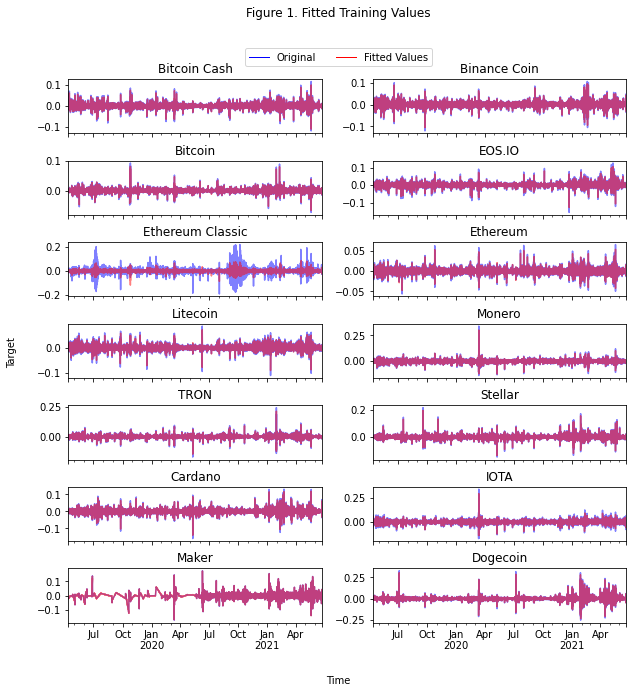

In [16]:
fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for i, (ax, asset) in enumerate(zip(axes, asset_details_df["Asset_ID"])):
    print(i)
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    fitted_values_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [18]:
del fig
del axes
del temp_df

gc.collect()

NameError: name 'fig' is not defined

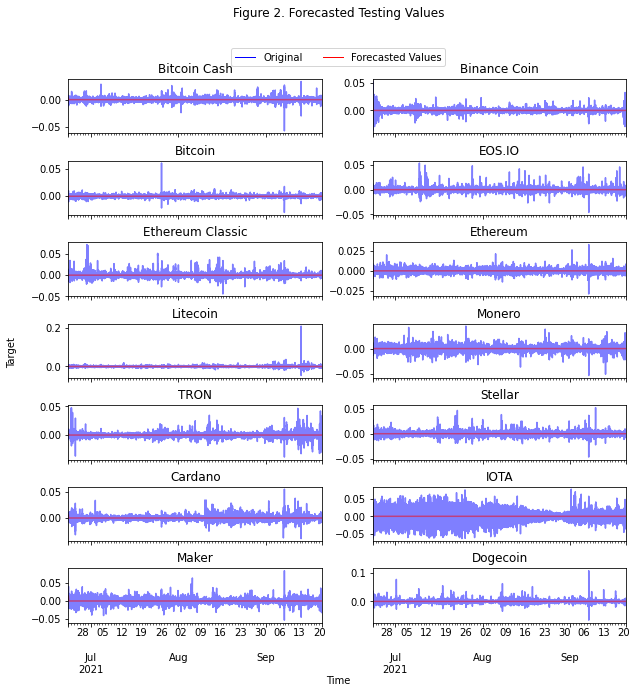

In [19]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

#num = 4
#temp_df = temp_df.iloc[::num, :]
#temp_fit = temp_fit.iloc[::num, :]

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for i, (ax, asset) in enumerate(zip(axes, asset_details_df["Asset_ID"])):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [ ]:
del temp_df
del temp_fit
gc.collect()